<a href="https://colab.research.google.com/github/richicaro/Project-Machine-Learning/blob/main/Progetto_optimization_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import typing

In [ ]:
import numpy as np
import scipy.linalg
import plotly.graph_objects as go
import time

To start, we generate a dataset with $d=50$ features and $m=1000$ samples and for reproducibility we set the seed *np.random.seed(21+100)*.

In [ ]:
np.random.seed(21+100)
def generate_dataset(d: int, m: int) -> typing.Tuple[np.array, np.array]:
    """Generate a dataset with d=50 features and m=1000 samples."""
    range_d = np.arange(d)
    cov = scipy.linalg.toeplitz(0.1**range_d)
    X = np.random.multivariate_normal(np.zeros(d), cov, size=m)
    w = (-1)**range_d * np.exp(- range_d / 10.)
    noise = np.random.randn(m)
    y = np.dot(X, w) + noise
    return X, y

The above code has the following goal (line by line):


1. The first line generates an array containing integers from 0 to $d-1$
2. The second line produces a Toeplitz matrix using the values of 0.1 raised to the power of each element in *range_d*. Toeplitz matrices have constant values along each diagonal, and in this case, the values decrease exponentially.

1. The third line generates a multivariate normal distribution with mean zero and covariance matrix *cov*. The resulting array $X$ has $m$ samples, each with $d$ features.
2. This line creates an array $w$ with values alternating in sign and decreasing exponentially. This array represents the true coefficients for the linear relationship between features and the target variable.

1. Here, an array noise is generated with random values from a standard normal distribution *(mean 0, standard deviation 1)*. This represents the noise in the relationship between features and the target variable.
2. Finally, the target variable $y$ is calculated by taking the dot product of the feature matrix $X$ and the true coefficients $w$ adding the random noise.










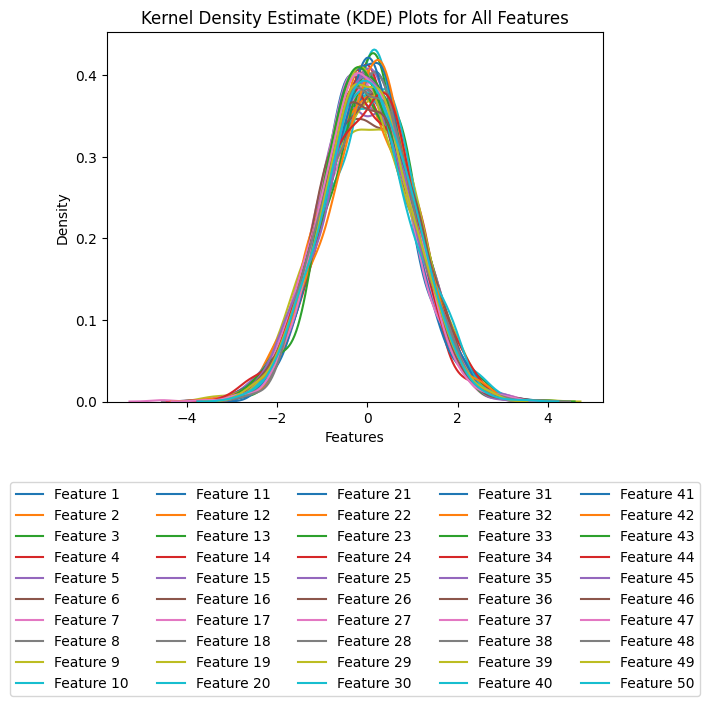

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
np.random.seed(21+100)
# Call the generate_dataset function
d = 50
m = 1000
X, y = generate_dataset(d, m)

# Create KDE plots for all features
for feature_index in range(d):
    sns.kdeplot(X[:, feature_index], label=f'Feature {feature_index + 1}')

plt.xlabel('Features')
plt.ylabel('Density')
plt.title('Kernel Density Estimate (KDE) Plots for All Features')
plt.legend(bbox_to_anchor=(0.5, -0.2), loc="upper center", ncol=5)
plt.show()

Plot of the density of all the features generated through the function *generate dataset*.

Now, before to implement the evaluation of the empirical risk associated to our generated dataset, we first start by implementing the prediction function. Since we have 50 features, than $n=51$ (50 features plus one bias) where the first $n-1$ weights are associated to the corresponding features and the last one is the bias.

$\stackrel{\wedge}{y}=\sum_{i=0}^{n-1} w^{(i)} x^{(i)}+w^{(n)}$

In [ ]:
def y_hat(x_j: float, w: np.ndarray) -> float:
    return np.dot(w[:-1], x_j) + w[-1]

After that, I can compute the least square loss and its derivative:

$\ell(x;y;w)=(\sum_{i=0}^{n-1} w^{(i)} x^{(i)}+w^{(n)}-y)^2$

while its derivaty is the following:

$\nabla_w \ell(x;y;w)=2\cdot(\sum_{i=0}^{n-1} w^{(i)} x^{(i)}+w^{(n)}-y)\cdot \begin{bmatrix} x \\ 1 \end{bmatrix}$



In [ ]:
def least_squares_loss(x_j: float, y_j: float, w: np.ndarray) -> float:
    return (y_hat(x_j, w) - y_j)**2

In [ ]:
def grad_least_squares_loss(x_j: float, y_j: float, w: np.ndarray) -> np.ndarray:
    vec = np.zeros(w.shape[0])
    vec[:-1] = x_j
    vec[-1] = 1
    return 2 * (y_hat(x_j, w) - y_j) * vec

Now I can set the evaluation of the empirical risk (and its gradient) associated to a lianear regression via least squares with multiple features ($d=50$). The below function have two arguments:

1. $w$: represents a vector with $n=d+1$
2. Addend: is an optional argument that if it is set to None the empirical risk is computed on the whole dataset. Otherwise, if it is a natural number $j$ then the empirical risk should return the *least square loss* associated to the j-th row of our generated dataset.



In [ ]:
def f1(w: np.ndarray,addend: typing.Optional[int] = None) -> float:
  if addend is None:
    m=X.shape[0]
    return 1 / m * sum(least_squares_loss(x_j, y_j, w) for (x_j, y_j) in zip(X,y))
  else:
    return least_squares_loss(X[addend],y[addend],w)

In [ ]:
def grad_f1(w: np.ndarray, addend: typing.Optional[int] = None) -> np.ndarray:
    if addend is None:
      m=X.shape[0]
      return 1 / m * sum(grad_least_squares_loss(x_j, y_j, w) for (x_j, y_j) in zip(X, y))
    else:
        return grad_least_squares_loss(X[addend], y[addend], w)

Now, in order to understand how the strong convexity constant $u$ and the smooth constant $L$ of the empirical risk relate to the eigenvalues of $X^TX$,
we need to compute the eigenvalues of hessian matrix $\nabla^2 f(w)$

$L=2\cdot \frac{\lambda_{max} X^TX}{m}$

$u=2\cdot \frac{\lambda_{min} X^TX}{m}$

In [ ]:
eigs, _ = np.linalg.eig(np.dot(X.T, X))
m=X.shape[0]
L = np.round((2 * np.max(eigs) / m),8)
print("L =", L)

L = 3.24558783


In [ ]:
eigs, _ = np.linalg.eig(np.dot(X.T, X))
u = np.round((2 * np.min(eigs) / m),2)
print("u =", u)

u = 1.12


Having a strictly positive $u$ means that the empirical risk is strongly convex, which can be beneficial for optimization. Strong convexity is a desirable property for optimization problems because it implies that the objective function has a unique global minimum. However, if $\lambda_{min}$is negative, it means that the Hessian matrix is not positive definite, and the function may not be strongly convex.
Moreover, having a finite and positive $L$ implies that the empirical risk is
*L-smooth*, which is a desirable property for optimization algorithms.
Those two are positive results since we know from the theory that:

let $f:R \rightarrow R$ be an *L-smooth* and *u-strongly convex* function. The there is a unique global minimum $w^*$. Considering the gradiend descendent method with constant step length $\alpha=1/L$, applied starting from $w_0$, at its $k$-$th$ iteration. Then,

$f(w_{k+1})-f(w^*)<=(1-\frac{u}{L})\cdot (f(w_k)-f(w^*))$

What is important to remember is that when $\alpha=1/L$, for the error in the function value convergence rate is linear $(1-\frac{u}{L})^k$ and $O(\frac{L}{u}log{\epsilon^{-1}})$ as number of iterations to get to the desired tollerance.

In the following code, I implemented the gradient descendent method. Such method is an iterative algorithm composed by the following steps: first we choose an initial point $w_0 \in R^n$, then for $k=1,2...$

1. compute the gradient $[\nabla f](w_k)$
2. compute the steph length $a_k>0$

1. set $w_{k+1}=w_k-\alpha_k \cdot [\nabla f](w_k)$

end for





In our context the inputs of our python functions are:

* The function $f$;
* The gradient $\nabla f$;

* The value of $u$ and $L$ that I computed before;
* A string that controls how the successive step lengths are generated, respectively: ***constant*** $\alpha_k=\frac{1}{L}$, ***inverse_linear*** $\alpha_k=\frac{1}{u k+L}$ or inverse square root to generate $\alpha_k=\frac{1}{\sqrt{u^{2}k+L^2}}$

* max number of iterations
* the tolerance $\epsilon$ for the stopping criterion based on the norm of the gradient








In [ ]:
def SGD(f: typing.Callable, grad_f: typing.Callable, u: float, L: float, maxit: int, epsilon: float, w_0: np.ndarray, alpha: str) -> typing.Tuple[np.ndarray, np.ndarray, np.ndarray]:
    alpha_mapping = {
        "constant": lambda k: 1 / L,
        "inverse_linear": lambda k: 1 / (u * k + L),
        "inverse_square_root": lambda k: 1 / np.sqrt(u**2 * k + L**2)
    }
    all_w = [w_0]
    all_f = [f(w_0)]
    all_grad_f = [grad_f(w_0)]
    k = 0

    while np.linalg.norm(all_grad_f[k]) > epsilon:
        w_k = all_w[k]
        f_k = all_f[k]
        grad_k = all_grad_f[k]

        if alpha in alpha_mapping:
            p_k = grad_k
            alpha_k = alpha_mapping[alpha](k)
        else:
            raise ValueError("Invalid value for alpha")

        w_k_plus_1 = w_k - alpha_k * p_k

        all_w.append(w_k_plus_1)
        all_f.append(f(w_k_plus_1))
        all_grad_f.append(grad_f(w_k_plus_1))

        if all_f[k + 1] >= all_f[k]:
          print("WARNING: descent conditions are not satisfied")
          break

        k += 1
        if k>maxit:
          break

    return np.array(all_w), np.array(all_f), np.array(all_grad_f)

In [ ]:
initial_w=np.zeros(X.shape[1]+1)

In [ ]:
w_c,f_c,grad_c = SGD(f1,grad_f1, u, L,600,1e-8, initial_w, "constant")
w_i,f_i,grad_i= SGD(f1,grad_f1, u, L,600,1e-8, initial_w, "inverse_linear")
w_is,f_is,grad_is = SGD(f1,grad_f1, u, L,600,1e-8, initial_w, "inverse_square_root")

In [ ]:
fig_function_value = go.Figure()
fig_gradient_norm = go.Figure()

# Add scatter traces for constant learning rate
fig_function_value.add_trace(go.Scatter(x=np.arange(len(f_c)), y=f_c, mode='lines+markers', name="Constant"))
fig_gradient_norm.add_trace(go.Scatter(x=np.arange(len(grad_c)), y=np.linalg.norm(grad_c, axis=1), mode='lines+markers', name="Constant (Gradient Norm)"))

# Add scatter traces for inverse linear learning rate
fig_function_value.add_trace(go.Scatter(x=np.arange(len(f_i)), y=f_i, mode='lines+markers', name="Inverse Linear"))
fig_gradient_norm.add_trace(go.Scatter(x=np.arange(len(grad_i)), y=np.linalg.norm(grad_i, axis=1), mode='lines+markers', name="Inverse Linear (Gradient Norm)"))

# Add scatter traces for inverse square root learning rate
fig_function_value.add_trace(go.Scatter(x=np.arange(len(f_is)), y=f_is, mode='lines+markers', name="Inverse Square Root"))
fig_gradient_norm.add_trace(go.Scatter(x=np.arange(len(grad_is)), y=np.linalg.norm(grad_is, axis=1), mode='lines+markers', name="Inverse Square Root (Gradient Norm)"))
# Update layout for function value plot
fig_function_value.update_layout(
    title="Semilogarithmic Plot of Function Value",
    xaxis_title="Iteration",
    yaxis_title="Function Value (log scale)",
    yaxis_type="log",
    showlegend=True
)

# Update layout for gradient norm plot
fig_gradient_norm.update_layout(
    title="Semilogarithmic Plot of Norm of Gradients",
    xaxis_title="Iteration",
    yaxis_title="Gradient Norm (log scale)",
    yaxis_type="log",
    showlegend=True
)

# Show the plots
fig_function_value.show()
fig_gradient_norm.show()

The plots above show: the first one the three different trends for the loss functions for the three different values of the learning rate; while the second plot show the trends of the norn of the gradient with respect to the three different learning rate.
From the graphs we may conclude that: if $\alpha_k=\frac{1}{L}$ or $\alpha_k=\frac{1}{\sqrt{u^2 k+L^2}}$ the loss function diverges without reaching the minimum. On the other case, when $\alpha_k=\frac{1}{uk+L}$ the function converges even if slowly. Moreover, the second plot, relatively to the norm of the gradient, helps us to better understand why this value of $a$ is better than the other two.
We may add that if the loss seems flat, but the gradient norm still shows some variation, it could be due to the differences in scale (in the loss function the scale depends on the nature of the problem while as far as the gradient is concerned the scale depends on the scale of the parameters of the model). In this case, it is possible that the model is making progress in terms of updating parameters (as indicated by the change in the gradient norm), but this progress may be too small to have a significant impact on the loss function because of its scale.
To address this issue, we might consider to use a larger learning rate (if the gradient norm is still significant) so that parameter updates are more "influential" on the loss function.
In conclusion we may add that the convergence is sublinear.

Now I implemented a *mini_batch stochastic method* where the size of the mini_batch is eual to $m_b=\frac{m}{10}$ and a maximum number of epochs, $E_{max}=100$. The mini_batch SM algorithm works in this way:
given an initial point $w_0 \in R^n$,for $k=1,2...$, we have the following steps:



1. draw $m_b$ random indeces $j_k$ $\subset$ {${1,...m}$}, |$j_k$|=$m_b$
2. compute the update direction $g_k=-\frac{1}{m_b}\sum\limits_{j \in j_k}[\nabla f_j](w_k)$

1. compute the step length $\alpha_k>0$
2. set $w_{k+1}=w_k+\alpha_k*g_k$

I trained the model for different values of $\alpha$:

* $\alpha_k=1/L$
* $\alpha_k=\frac{\alpha_0}{(k+1)}$ where $\alpha_0=1/L$

* $\alpha_k=\frac{\alpha_0}{\sqrt{k+1}}$, again $\alpha_0=1/L$

Then, I printed the total number of iterations but also the total number of epocs defined as:

$E=k\cdot \frac{m_b}{m}$

It is also important to remind that in the case of the mini_batch stochastic method, an iteration requires the computation of $\sum\limits_{j \in J_k]}\nabla f_j(w)$ where $|J_k|=m_b$. Therefore 1 epoch=$\frac{m}{m_b}$.

Using the number of epochs gives us a fair comparison in terms of run time
when comparing different methods. A comparison in terms of numbers of
iterations is not fair, because methods have different cost per iteration.

The goal here is to make the plot of the norm of the gradient (related to the different values of $\alpha$) vs the number of iterations and versus the number of epocs  to see which learning rate is better and which plot is more helpfull to make our conclusion.








In [ ]:
def mini_batch_SGM(
    m: int, m_b: int, f: typing.Callable, grad_f: typing.Callable, alpha: str,
    epsilon: float, maxep: int, w_0: np.ndarray
) -> typing.Tuple[np.ndarray, np.ndarray, np.ndarray]:

    assert alpha in ("constant", "inverse_linear", "inverse_square_root")
    alpha0=1/L
    alpha_mapping = {
        "constant": lambda k: alpha0,
        "inverse_linear": lambda k: alpha0 / (k+1),
        "inverse_square_root": lambda k: alpha0 / np.sqrt(k+1)
        }

    all_w = [w_0]
    all_f = [f(w_0)]
    all_grad_f = [grad_f(w_0)]

    k = 0  # Start from 1 since we've already done the first step
    while np.linalg.norm(all_grad_f[k]) > epsilon and k<maxep*m/m_b:
      w_k = all_w[k]
      j_k = np.random.choice(m, size=m_b, replace=False)
      g_k = (1 / m_b) * sum([grad_f(w_k, addend=j) for j in j_k])
      if alpha in alpha_mapping:
        alpha_k = alpha_mapping[alpha](k)
      else:
        raise ValueError("Invalid value for alpha")

      w_k_plus_1 = w_k - alpha_k * g_k

      all_w.append(w_k_plus_1)
      all_f.append(f(w_k_plus_1))
      all_grad_f.append(grad_f(w_k_plus_1))

        #if all_f[k] >= all_f[k - 1]:
         # print("WARNING: descent conditions are not satisfied")
          #break

      k += 1
    return np.array(all_w), np.array(all_f), np.array(all_grad_f)

In [ ]:
np.random.seed(21+700)
all_w=dict()
all_f=dict()
all_grad_f=dict()
alphas=['constant','inverse_linear','inverse_square_root']
m_b=m//10
for alpha in alphas:
  start=time.time()
  all_w[alpha],all_f[alpha],all_grad_f[alpha]= mini_batch_SGM(1000,100,f1,grad_f1,alpha,1e-3,100,initial_w)
  end=time.time()
  K=all_w[alpha].shape[0]
  E=int(np.ceil(K*m_b/m))
  print("m_b =", m_b, "out of", m, "converged in", K, "iterations,",E, "epochs and", end - start, "seconds",'alpha',alpha)

m_b = 100 out of 1000 converged in 1001 iterations, 101 epochs and 10.549453496932983 seconds alpha constant
m_b = 100 out of 1000 converged in 1001 iterations, 101 epochs and 10.963965654373169 seconds alpha inverse_linear
m_b = 100 out of 1000 converged in 1001 iterations, 101 epochs and 11.349980354309082 seconds alpha inverse_square_root


In [ ]:
np.random.seed(21+700)
fig1 = go.Figure()
fig2=go.Figure()
# Iterare su tutte le alphas e fare il plot della norma del gradiente

for alpha in alphas:
    grad_norms=np.linalg.norm(all_grad_f[alpha],axis=1)
    grad_norms1 = [np.linalg.norm(all_grad_f[alpha][2:,:], axis=1)[c] for c in range(0,1000,10)]
    iterations = np.arange(1001)
    epocs=np.arange(100)
    # Aggiungere una traccia per ogni alpha
    fig1.add_trace(go.Scatter(x=iterations, y=grad_norms, mode='lines', name=f'Alpha={alpha}'))
    fig2.add_trace(go.Scatter(x=epocs, y=grad_norms1, mode='lines', name=f'Alpha={alpha}'))

# Aggiungere le etichette e la legenda al plot
fig1.update_layout(
    xaxis_title='Iterations',
    yaxis_title='Gradient Norm',
    title='Convergence of Gradient Norm for Different Alpha Values',
    legend=dict(title='Alpha'),
    yaxis_type='log'
)
fig2.update_layout(
    xaxis_title='epochs',
    yaxis_title='Gradient Norm',
    title='Convergence of Gradient Norm for Different Alpha Values',
    legend=dict(title='Alpha'),
    yaxis_type='log'
)

fig1.update_xaxes(range=[0, 1100])
fig2.update_xaxes(range=[0,110])

# Mostrare il plot
fig1.show()
fig2.show()

Looking at the two plots above I may conclude that the value for $\alpha_k$ that is better is the second one (inverse_linear) as before, where $\alpha_k=\frac{\alpha_0}{k+1}$ and $\alpha_0=1/L$. Moreover, between the plots of the norm of the gradient vs the number of iterations and the one after versus the epocs, the latter looks like more helpfull. This is because it provides a more aggregated view of the optimization process, highlighting trends on a larger scale and simplifying comparisons between different configurations or methods. However, we have to underscore that if we want to focus on how the gradient norm evolves on a larger scale and how it varies with respect to the total number of epochs, the graph with respect to epochs may be more useful. On the other hand, if you want to examine specific details of the convergence process, the graph versus iterations may be more appropriate.

Now, I keep the implementation of the *mini_batch stochastic method* made before but this time $\alpha_k=\frac{\alpha_0}{k+1}$, and I train the model for different sizes of the batch. In particuare $m_b=[50,100,500,1000]$.
In this section, always using the plot of the norm of the gradient versus the number of iterations and versus the number of epocs, the goal is to see what batch better captures the features of our data.

In [ ]:
np.random.seed(21+800)
all_w1=dict()
all_f1=dict()
all_grad_f1=dict()
mini_batches=[50,100,500,1000]
for m_b in mini_batches:
  start=time.time()
  all_w1[m_b],all_f1[m_b],all_grad_f1[m_b]=mini_batch_SGM(1000,m_b,f1,grad_f1,'inverse_linear',1e-3,100,initial_w)
  end=time.time()
  K=all_w1[m_b].shape[0]
  E=int(np.ceil(K*m_b/m))
  print("m_b =", m_b, "out of", m, "converged in", K, "iterations,",E, "epochs and", end - start, "seconds",'method:inverse_linear')

m_b = 50 out of 1000 converged in 2001 iterations, 101 epochs and 20.768832445144653 seconds method:inverse_linear
m_b = 100 out of 1000 converged in 1001 iterations, 101 epochs and 18.064995050430298 seconds method:inverse_linear
m_b = 500 out of 1000 converged in 201 iterations, 101 epochs and 2.909269094467163 seconds method:inverse_linear
m_b = 1000 out of 1000 converged in 101 iterations, 101 epochs and 1.5957567691802979 seconds method:inverse_linear


In [ ]:
np.random.seed(21+800)
fig1 = go.Figure()
fig2=go.Figure()

# Iterare su tutte le alphas e fare il plot della norma del gradiente
iterations={50:(2000,20),100:(1000,10),500:(200,2),1000:(100,1)}

iter=[50,100,500,1000]
for m_b in iter:
  iterations={50:(2000,20),100:(1000,10),500:(200,2),1000:(100,1)}
  grad_norms = np.linalg.norm(all_grad_f1[m_b], axis=1)
  grad_norms1 = [np.linalg.norm(all_grad_f1[m_b], axis=1)[c] for c in range(0,iterations[m_b][0],iterations[m_b][1])]
  iterations = np.arange(1, grad_norms.shape[0])
  epocs = np.arange(100)
    # Aggiungere una traccia per ogni alpha
  fig1.add_trace(go.Scatter(x=iterations, y=grad_norms, mode='lines', name=f'Mini_Batch={m_b}'))
  fig2.add_trace(go.Scatter(x=epocs, y=grad_norms1, mode='lines',name=f'Mini_Batch={m_b}'))

# Aggiungere le etichette e la legenda al plot
fig1.update_layout(
    xaxis_title='Iterations',
    yaxis_title='Gradient Norm',
    title='Convergence of Gradient Norm for Different Alpha Values',
    legend=dict(title='Mini_Batch'),
    yaxis_type='log'
)
fig2.update_layout(
    xaxis_title='epochs',
    yaxis_title='Gradient Norm',
    title='Convergence of Gradient Norm for Different Alpha Values',
    yaxis_type='log',
    legend=dict(title='Mini_Batch')
)

fig1.update_xaxes(range=[0, 2100])
fig2.update_xaxes(range=[0,110])

# Mostrare il plot
fig1.show()
fig2.show()

Even in this case the plot of the norm of the gradient versus the number of epocs helps us in a better way to define what is the mini_batch that is more suitable of our problem. Analysing the plot, we may conclude that the best solution is to choose $m_b=100$ since the norm of the gradient reaches a lower value in comperison with the other cases.

***Regularization techniques***

A regularization or composite problem is an optimization problem
$\min\limits_{w \in R^n} f(w)$ where the function $f:R^n \rightarrow R$ has the following additive form:

$f(w)=s(w)+\gamma r(w)$

where:

1. the function $s:R^n \rightarrow R$ is a smooth function;
2. the number $\gamma>0$ is a positive regularitazion coefficient;

1. the function $r:R^n \rightarrow R$ is a convex but not necessarily smooth function called *regularizer*

Important to underscore that in machine learning $s(w)$ is typically the empirical risk and the regularized term is supposed to penalize undesired values of the weights.
Moreover, the regularization coefficient balances the tradeoff between empirical risk and regularization.
if λ = 0 we are back to the unregularized problem,

*  if $\gamma=0$ we are back to the unregularized problem;
*  if $\gamma$ ≈ $0$ it means that we are only mildly interested in penalizing
“undesired” values of the weights, and would prefer to have a small
empirical risk;

*  if $\gamma>>0$ it means that we are very much requiring the weights do have
“desired” values, even if that means having a moderately large empirical.

One choice, according to our notes 'the simplest one', would be to choose the regulizer as:

$r(w)=||w||_2^2=(||w||_2)^2$ ($l_2$ norm).

This technique is known as weight decay in machine learning.








However,in our problem we choose $r(w)=||w||_1:=\sum^{n}\limits_{i=1} |w^{(i)}|$. leads to a regularization technique that is known as ***LASSO regression***. In this case, the LASSO regularizer r is not smooth, because the function r is
not differentiable at the edges. Hence, with the additional terms $r$ we have turned a smooth problem for $s$ into a non-smooth one for $f$. In addition, since the function $r$ is not differentiable at some points we better recall the definition of *L-lipschitz function*: a function $r:R^n \rightarrow R$ is a L-lipschitz function if there exist $L>0$ such that for any $w,v \in R^n$ we have:

$|r(w)-r(v)|<=L ||w-v||$

Important to remind that if $r:R^n \rightarrow R$ is a L-lipschitz function than it is also continous. Moreover, being a L-lipschitz function implies differentiability almost everywhere. Since there are only a few points at which a L-lipschitz function is not differentiable we can 'save' the gradient method algorithm implementing the so called ***subgradient method***.

This algoritmic method works in the following way:
given an initial point $w_0 \in R^n$, for $k=1,2...$

*  Compute the subgradient $g_k \in \delta f(w_k)$;
*  Compute the steph length $\alpha_k>0$;

*  Set $w_{k+1}=w_k-\alpha_k g_k$

Moreover, if f is differentiable at $w_k$, then $\delta f(w_k) = {∇f(w_k)}$, and this is exactly the
same as one iteration of the standard gradient method.







In [ ]:
def norm_1(w, gamma=0):
    w = np.array(w)  # Convert to NumPy array
    norm_value = np.linalg.norm(w, 1)  # ℓ₁ norm

    # Gradient computation
    subgradient = np.where(w < 0, -1, np.where(w > 0, 1, gamma))

    return norm_value, subgradient

The function above named as *norm_1* return two outputs:

1. $||w||_1$, where $r(w)=||w||_1$
2. subgradient norm of $r$ for any $\gamma \in [-1,1]$ defined as:

$ g^{(i)}=\begin{align}
    -1 \ \ if \ \ w^{(i)}<0 \\
    \gamma \ \ if \ \ w^{(i)}=0 \\
    1 \ \ if \ \ w{(i)}>0
  \end{align}$

  Where $\gamma=0$ in our problem.



In [ ]:
lambda_=1/np.sqrt(X.shape[0])

As before, I implemented the evaluation of the empirical risk associated to a linear regression via least squares adding $\lambda \cdot ||w||_1$ term to the loss function (called as $s$) and $\lambda \cdot g^{(i)}$ to the gradient of the loss ($\Delta s$).

In [ ]:
def least_squares_loss1(x_j: float, y_j: float, w: np.ndarray) -> float:
    norm_value,_=norm_1(w,gamma=0)
    return (y_hat(x_j,w)-y_j)**2 + lambda_ * norm_value

In [ ]:
def grad_least_squares_loss1(x_j: float, y_j: float, w: np.ndarray) -> np.ndarray:
    vec = np.zeros(w.shape[0])
    vec[:-1] = x_j
    vec[-1] = 1
    _,subgradient=norm_1(w,gamma=0)
    return 2 * (y_hat(x_j, w) - y_j) * vec + lambda_ * subgradient

In [ ]:
def f_reg(w: np.ndarray,addend: typing.Optional[int] = None) -> float:
  if addend is None:
    m=X.shape[0]
    return 1 / m * sum(least_squares_loss1(x_j, y_j, w) for (x_j, y_j) in zip(X,y))
  else:
    return least_squares_loss1(X[addend],y[addend],w)

In [ ]:
def grad_f_reg(w: np.ndarray, addend: typing.Optional[int] = None) -> np.ndarray:
    if addend is None:
      m=X.shape[0]
      return 1 / m * sum(grad_least_squares_loss1(x_j, y_j, w) for (x_j, y_j) in zip(X, y))
    else:
        return grad_least_squares_loss1(X[addend], y[addend], w)

Now I implemented the *unreg_SGD function* that takes as argument: $s,\Delta s,$, the regularizaion coefficient $\lambda$ (above defined as $\lambda=\frac{1}{\sqrt{m}}$), the regulizer function r (in our case $r(w)=||w||_1$), a function that computes one of $r$ subgradients (the last two results can be gotten from the function called ***norm_1***), a string that controls how different $\alpha$ guesses where $\alpha_0=\frac{1}{L}$ are generated:



* $\alpha=1/L$ constant;
* $\alpha=\frac{\alpha_0}{k+1}$ inverse linear;

* $\alpha=\frac{\alpha_0}{\sqrt{k+1}}$ inverse square root

Then, the maximum number of iteration allowed: $K_{max}=200$, the tollerance $\epsilon=10^{-3}$ and the initial guess for the weights ($w$).
The regulizer function r (in our case $r(w)=||w||_1$) and the function that computes one of $r$ subgradients can be gotten from the function called ***norm_1***.
The function should return as output the optimization variables,the corresponding composite function values and the corresponding subgradient for the composite function values.

The goal is to see which plot is more usefull between a semilogartimic plot of the composite function values and the one of the its subgradient norms, versus the number of iterations (gotten for the three different values of $\alpha$) in order to determine which value of $\alpha$ is better.

In [ ]:
def unreg_SGD(f: typing.Callable, grad_f: typing.Callable,lambda_,maxit: int, epsilon: float, w_0: np.ndarray,alpha: str) -> typing.Tuple[np.ndarray, np.ndarray, np.ndarray]:
  alpha0=1/L
  alpha_mapping = {
      "constant": lambda k: 1 / L,
      "inverse_linear": lambda k: alpha0 / (k+1),
      "inverse_square_root": lambda k: alpha0 / np.sqrt(k+1)
    }

  all_w = [w_0]
  all_f = [f(w_0)]
  all_grad_f = [grad_f(w_0)]
  k = 0

  while np.linalg.norm(all_grad_f[k]) > epsilon:
    w_k = all_w[k]
    f_k = all_f[k]
    grad_k = all_grad_f[k]
    if alpha in alpha_mapping:
      p_k = grad_k
      alpha_k = alpha_mapping[alpha](k)
    else:
      raise ValueError("Invalid value for alpha")

    w_k_plus_1 = w_k - alpha_k * p_k

    all_w.append(w_k_plus_1)
    all_f.append(f(w_k_plus_1))
    all_grad_f.append(grad_f(w_k_plus_1))

        #if all_f[k + 1] >= all_f[k]:
          #print("WARNING: descent conditions are not satisfied")
          #break

    k += 1
    if k>maxit:
      break

  return np.array(all_w), np.array(all_f), np.array(all_grad_f)

In [ ]:
#lambda_=1/sqrt(m)
all_wr=dict()
all_fr=dict()
all_grad_fr=dict()
alphas=['constant','inverse_linear','inverse_square_root']
for alpha in alphas:
  all_wr[alpha],all_fr[alpha],all_grad_fr[alpha]=unreg_SGD(f_reg, grad_f_reg,lambda_,200,1e-3,initial_w, alpha)

In [ ]:
fig_function_unreg = go.Figure()
fig_gradient_norm_unreg = go.Figure()

for alpha in alphas:
  fig_function_unreg.add_trace(go.Scatter(x=np.arange(len(all_fr[alpha])), y=all_fr[alpha], mode='lines+markers', name=f"alpha: {alpha}"))
  fig_gradient_norm_unreg.add_trace(go.Scatter(x=np.arange(len(all_wr[alpha])), y=np.linalg.norm(all_grad_fr[alpha], axis=1),
                                             mode='lines+markers', name=f"alpha:{alpha}"))

fig_function_unreg.update_layout(
    title="Semilogarithmic Plot of Function Value",
    xaxis_title="Iteration",
    yaxis_title="Function Value (log scale)",
    yaxis_type="log",
    showlegend=True
)

# Update layout for gradient norm plot
fig_gradient_norm_unreg.update_layout(
    title="Semilogarithmic Plot of Norm of Gradients",
    xaxis_title="Iteration",
    yaxis_title="Gradient Norm (log scale)",
    yaxis_type="log",
    showlegend=True
)

# Show the plots
fig_function_unreg.show()
fig_gradient_norm_unreg.show()

From the plots I got I may conclude that the graph that is more usefull is the semilogaritmic plot of the subgradient norm. Moreover the value of $\alpha$ that may rapresent the best option is $\alpha=\frac{\alpha_0}{\sqrt{k+1}}$ (inverse_square_root) since the norm of the subgradient reaches the minimum point, even if there are margin for improvements since we record a problem of oscillations.

Now I have to implement a ISTA for our composite function $f(w)=s(w)+\lambda r(w)$ which takes as input the same arguments described for the previous function (even if the composite function and its subgradient is different, as I'm going to define).
Anyway,in this case, in order to find the minimum value for the waights that reduce our empirical risk, we have to use a different algorithm called ***proximal gradient method***. This algorithm is defined by the following steps: given an initial point $w_0 \in R^n$, for $K=1,2,...$:..

1. compute the gradient $[\Delta s](w_k)$
2. compute the step length $\alpha_k>0$

1. set $w_{k+1}=prox_{\lambda \alpha_k,r}(w_k-\alpha_k[\Delta s](w_k))$

This time, the algorithm requires to compute $[\Delta s](w_k)$ and not $\Delta f (w_k)$ which may not even exist at non differentiable points $w_k$. In addition, the regularizer function $r$ comes into play inside the *proximal operator*. For this reason when we recall $s$ and $\Delta$ as arguments of our ISTA function, we don't use the one describe before but instead this time those two arguments are basically equal to ***f1*** and ***gradf1*** described at the beginning.
For our problem, where we set $r(w)=||w||_1$ (*LASSO regularization*): $prox_{\eta,||.||_1}(z)=\underset{v \in \mathbb{R}^n}{\text{argmin}}\left\{\frac{1}{2} \cdot ||v-z||^2+\eta||v||_1\right\}$ can be evaluated using the soft-Tresholding function to each component z of the vector **z**.

$
S_{\eta}(z) = \begin{cases}
    z + \eta, & \text{if } z < -\eta \\
    0, & \text{if } -\eta \leq z \leq \eta \\
    z - \eta, & \text{if } z > \eta
\end{cases}
$

(In our case $z=w$).Now, considering the soft-tresholding function applied to our problem (remind we have a vector $w$ and not a scalar), we have:





In [ ]:
#def soft_thresholding(w:np.ndarray,eta:float) -> np.ndarray:
  #return (w+eta)*(w<-eta)+(w-eta)*(w>eta)

In [ ]:
def soft_thresholding1(w:np.ndarray,eta:float):
  return np.sign(w)*np.maximum(0,np.abs(w)-eta)

This fuction will change the values of $w$ (element wise) as in the system I described above.

In [ ]:
def ISTA(f: typing.Callable, grad_f: typing.Callable, lambda_: float,
         maxit: int, epsilon: float, w_0:
         np.ndarray, alpha: str) -> typing.Tuple[np.ndarray, np.ndarray, np.ndarray]:
  alpha0=1/L
  alpha_mapping = {
      "constant": lambda k: alpha0,
      "inverse_linear": lambda k: alpha0 / (k+1),
      "inverse_square_root": lambda k: alpha0 / np.sqrt(k+1)
      }
  all_w = [w_0]
  all_f = [f(w_0)]
  all_grad_f = [grad_f(w_0)]
  k = 0

  while np.linalg.norm(all_grad_f[k]) > epsilon:
      w_k = all_w[k]
      f_k = all_f[k]
      grad_k = all_grad_f[k]

      if alpha in alpha_mapping:
          p_k = -grad_k
          alpha_k = alpha_mapping[alpha](k)
      else:
          raise ValueError("Invalid value for alpha")

      w_k_plus_1 = soft_thresholding1(w_k+alpha_k*p_k,alpha_k*lambda_)

      all_w.append(w_k_plus_1)
      all_f.append(f(w_k_plus_1))
      all_grad_f.append(grad_f(w_k_plus_1))

        #if all_f[k + 1] >= all_f[k]:
          #print("WARNING: descent conditions are not satisfied")
          #break

      k += 1
      if k>maxit:
        break

  return np.array(all_w), np.array(all_f), np.array(all_grad_f)

Note that this time (as mentioned above) we don't have to add to our function the term $\lambda ||w||_1$ since it is handled seperatly by the ISTA algorithm. For this reason I recalled the function ***f1*** and ***grad_f1*** defined at the beginning and not the empirical lost e its gradient with the addition of the above term to compute the subgradient method.
It is enough to copy the implementation of ***SGD*** and only change the line that computes $w_{k+1}$+1  in order to apply the soft thresholding operator.

In [ ]:
np.random.seed(21+700)
lambda_=1/np.sqrt(X.shape[0])
all_wista=dict()
all_fista=dict()
all_grad_fista=dict()
alphas=['constant','inverse_linear','inverse_square_root']
for alpha in alphas:
  all_wista[alpha],all_fista[alpha],all_grad_fista[alpha]=ISTA(f1, grad_f1,lambda_,200,1e-3,initial_w, alpha)

In [ ]:
import plotly.graph_objects as go

fig_function_ISTA = go.Figure()
fig_gradient_ISTA = go.Figure()

for alpha in alphas:
    fig_function_ISTA.add_trace(go.Scatter(x=np.arange(len(all_wista[alpha])), y=all_fista[alpha], mode='lines+markers', name=f"alpha: {alpha}"))
    fig_gradient_ISTA.add_trace(go.Scatter(x=np.arange(len(all_wista[alpha])), y=np.linalg.norm(all_grad_fista[alpha], axis=1),
                                           mode='lines+markers', name=f"alpha: {alpha}"))

fig_function_ISTA.update_layout(
    title="Semilogarithmic Plot of Function Value",
    xaxis_title="Iteration",
    yaxis_title="Function Value (log scale)",
    yaxis_type="log",
    showlegend=True
)

fig_gradient_ISTA.update_layout(
    title="Semilogarithmic Plot of Norm of Gradients",
    xaxis_title="Iteration",
    yaxis_title="Gradient Norm (log scale)",
    yaxis_type="log",
    showlegend=True
)

fig_function_ISTA.show()
fig_gradient_ISTA.show()

The second plot may be more usefull to identify the best choice of $\alpha_k$. Moreover,looking at the second plot we may choose one between $\alpha=\frac{1}{L}$ and $\alpha=\frac{\alpha_0}{\sqrt{k+1}}$ where $\alpha_0=\frac{1}{L}$

Now, we compare the composite function that we got with the subgradient method with the one gotten with the ISTA algorithm

In [ ]:
import plotly.graph_objects as go

fig_function_1 = go.Figure()


fig_function_1.add_trace(go.Scatter(x=np.arange(len(all_wr['inverse_square_root'])), y=all_fr['inverse_square_root'],
                                    mode='lines+markers', name="subgradient"))
fig_function_1.add_trace(go.Scatter(x=np.arange(len(all_wista['inverse_square_root'])), y=(all_fista['inverse_square_root']),
                                    mode='lines+markers', name="ISTA"))

fig_function_1.update_layout(
    title="Semilogarithmic Plot of Function Value",
    xaxis_title="Iteration",
    yaxis_title="Function Value (log scale)",
    yaxis_type="log",
    showlegend=True
)

fig_function_1.show()


Looking at the above plot, I may conclude that the ISTA method with $\alpha=\frac{\alpha_0}{\sqrt{k+1}}$ is better.

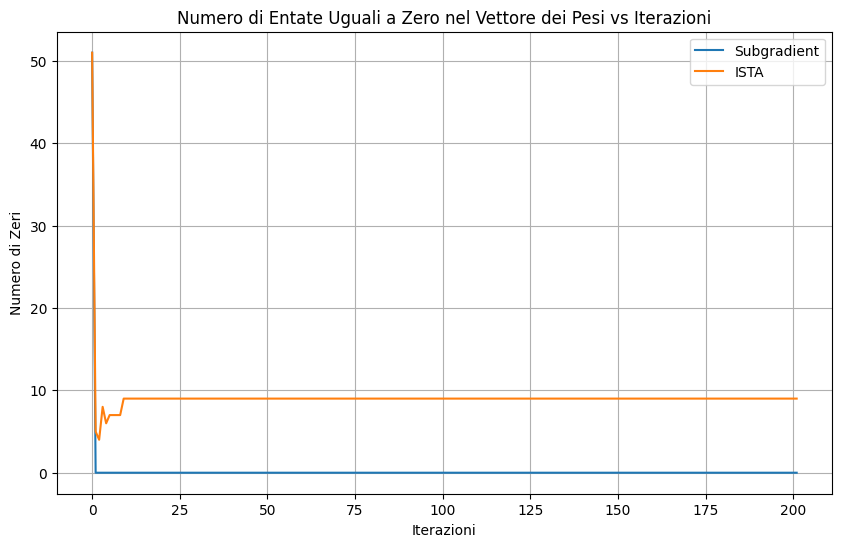

In [ ]:
zero_entries_subgradient = np.sum(all_wr['inverse_square_root'] == 0,axis=1)
zero_entries_ista = np.sum(all_wista['inverse_square_root']== 0,axis=1)
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(zero_entries_subgradient)), zero_entries_subgradient, label='Subgradient')
plt.plot(np.arange(len(zero_entries_ista)), zero_entries_ista, label='ISTA')
plt.title('Numero di Entate Uguali a Zero nel Vettore dei Pesi vs Iterazioni')
plt.xlabel('Iterazioni')
plt.ylabel('Numero di Zeri')
plt.legend()
plt.grid(True)
plt.show()

From the above plot, I plotted the number of zeros in the vector of weigths for both the results gotten with the subgradient and the ISTA method. I may conclude that the ISTA method promotes more sparsity. Hence, the best choice among them could depend on the context of the proble; if for instance we want to perform an 'aggressive' variable selection, we may choose the ISTA algorithm.
However, it's essential to balance sparsity with predictive performance, and hyperparameter tuning in both methods can be critical for achieving the desired balance.